# Tiled Imagery MAL

* Upload model inferences on tile imagery
* The example in the notebook uses a heuristic to prelabel water in the imagery

In [ ]:
!pip install labelbox
!pip install requests
!pip install mercantile
!pip install pygeotile
!pip install PILLOW
!pip install opencv-python
!pip install shapely

In [2]:
from labelbox.schema.ontology import OntologyBuilder, Tool
from labelbox import Client, LabelingFrontend
from io import BytesIO
from getpass import getpass
import uuid
import numpy as np
from PIL import Image
import cv2
import requests
from typing import List, Tuple
import ndjson
import os
from dataclasses import dataclass
from pygeotile.point import Point
from pygeotile.tile import Tile
from shapely.geometry import Polygon, box
import mercantile
import requests

In [3]:
# If you don't want to give google access to drive you can skip this cell
# and manually set `API_KEY` below.
COLAB = "google.colab" in str(get_ipython())
if COLAB:
    !pip install colab-env -qU
    from colab_env import envvar_handler
    envvar_handler.envload()

API_KEY = os.environ.get("LABELBOX_API_KEY")
if not os.environ.get("LABELBOX_API_KEY"):
    API_KEY = getpass("Please enter your labelbox api key")
    if COLAB:
        envvar_handler.add_env("LABELBOX_API_KEY", API_KEY)

In [4]:
# Only update this if you have an on-prem deployment
ENDPOINT = "https://api.labelbox.com/graphql"

In [5]:
client = Client(api_key=API_KEY, endpoint=ENDPOINT)

### Project Setup

In [6]:
# We want to try out a few different tools here.
ontology_builder = OntologyBuilder(tools=[
    Tool(tool=Tool.Type.POLYGON, name="water")
])

In [7]:
# This notebook only uploads data for a single dataRow.

# Select the region to label within the image

@dataclass
class GeoPoint:
    lat: float
    lng: float
        
@dataclass
class GeoBoundary:
    bottom_left: GeoPoint
    top_right: GeoPoint
        
        
bounds = GeoBoundary(
    bottom_left = GeoPoint(
        lat =  37.87276155898985, 
        lng =  -122.31764674186705
    ),
    top_right = GeoPoint(
        lat =  37.87398109727749, 
        lng =  -122.31635199317932
    )
)


# Set the image to label
img_info = {
  "tileLayerUrl": "https://public-tiles.dronedeploy.com/1499994155_DANIELOPENPIPELINE_ortho_qfs/{z}/{x}/{y}.png?Policy=eyJTdGF0ZW1lbnQiOlt7IlJlc291cmNlIjoiaHR0cHM6Ly9wdWJsaWMtdGlsZXMuZHJvbmVkZXBsb3kuY29tLzE0OTk5OTQxNTVfREFOSUVMT1BFTlBJUEVMSU5FX29ydGhvX3Fmcy8qIiwiQ29uZGl0aW9uIjp7IkRhdGVMZXNzVGhhbiI6eyJBV1M6RXBvY2hUaW1lIjoyMTQ1OTE0MTE4fX19XX0_&Signature=O~50rrGXdEC6Hi8jPJ3dbT~UtBd7Cw6iQPTxdJ8LU2IaoxeP22R3JpKPkLN3T3~Lcw3CyX7uft2Baj0MH93qUoCYyN~~jNX3OMkYV2jbrHDezf6zQRHAabXX-L2bL-JEGfFL6z3DWccOFeCH56CuhgC29k5CJx7I34P-LQJdnAUsA-KaqKH1IyYsHStRIfmMzdXNAWU58FTfqVljq9SbKXxfgdr2SZ~7VgLaZ8IhA0WnlKUo-JgqTd~jYa5mGCpR8351IMK0aMuY4Mld4SOXssQ-rOtlZtypvo8FDp474TlGIEGz5PHxGOPsqLPF19hEYTgoPqsUj8QEuiTfg-cmsg__&Key-Pair-Id=APKAJXGC45PGQXCMCXSA",
  "bounds": [
      [bounds.bottom_left.lat, bounds.bottom_left.lng],
       [bounds.top_right.lat, bounds.top_right.lng]
  ],
  "minZoom": 10,
  "maxZoom": 23,
  "epsg": "EPSG4326"
}



In [8]:
# Lets setup the project
# Note see Ontology, Project, and Project_setup notebooks for more information on this section.

project = client.create_project(name="tms_mal_project")
dataset = client.create_dataset(name="tms_mal_dataset")

# DataRows can only be created as bulk operations for tiled imagery data

dataset.create_data_rows([img_info])
editor = next(
    client.get_labeling_frontends(where=LabelingFrontend.name == "Editor"))
project.setup(editor, ontology_builder.asdict())
project.datasets.connect(dataset)

In [8]:
project.enable_model_assisted_labeling()

True

* <b>Grab featureSchemaIds</b>
* This enables us to assign model inferences to a specific class in labelbox
* Checkout the ndjson section to see where this is used

In [9]:
# When we created a project with the ontology defined above, all of the ids were assigned.
# Let's reconstruct the ontology builder with all of the ids.
ontology = ontology_builder.from_project(project)
# We want all of the feature schemas to be easily accessible by name.
schema_lookup = {tool.name: tool.feature_schema_id for tool in ontology.tools}
print(schema_lookup)

{'water': 'ckns6zi4p05ig0yalaopgdcuj'}


### Create import objects
* We want to create a polygon json payload that matches the format documented here : https://docs.labelbox.com/data-model/en/index-en#polygon

In [ ]:
# Create helper functions

def tile_generator(bounds: GeoBoundary, zoom : int):
    # Returns all tiles that intersect with the provide bounds
    bds = box(bounds.top_right.lng, bounds.top_right.lat, bounds.bottom_left.lng, bounds.bottom_left.lat).bounds
    for tile in mercantile.tiles(*bds, zooms=[zoom]):
        yield tile

def tile_to_box(tile: Tile) -> Polygon:
    # Converts a Tile object to a shapely Polygon in pixel space
    tile_bounds = Tile.from_google(tile.x, tile.y, tile.z).bounds
    tile_bounds = [ptt.pixels(zoom = tile.z) for ptt in tile_bounds]
    return box(tile_bounds[1][1],tile_bounds[0][0],tile_bounds[0][1] , tile_bounds[1][0])

def geo_boundary_to_box(bounds : GeoBoundary) -> Polygon:
    # Converts a wgs84 GeoBoundary into a shapely Polygon in pixel space
    y2, x2 = Point.from_latitude_longitude(latitude = bounds.top_right.lat, longitude = bounds.top_right.lng).pixels(zoom = tile.z)
    y1, x1 = Point.from_latitude_longitude(latitude = bounds.bottom_left.lat,longitude =  bounds.bottom_left.lng).pixels(zoom = tile.z)
    return box(x1, y1,x2, y2)

def get_bounds_for_tile(bounds : GeoBoundary, tile : Tile) -> Tuple[Tuple[int,int,int,int], Polygon]:
    # Finds the intersection between the tms tile and the user specified GeoBoundary
    # Converts the intersection into pixel space relative to the GeoBoundary
    tile_bounds_box = tile_to_box(tile)
    target_bounds_box = geo_boundary_to_box(bounds)
    # Coords of overlapping region in px space
    intersection = target_bounds_box.intersection(tile_bounds_box)
    min_x,min_y,max_x, max_y = intersection.bounds
    # Convert to image space
    tile_bounds = tile_bounds_box.bounds
    min_x -= tile_bounds[0]
    max_x -= tile_bounds[0]
    min_y -= tile_bounds[1]
    max_y -= tile_bounds[1]
    return [int(x) for x in [min_x, min_y, max_x, max_y]], intersection

def get_image(tile : Tile, url : str) -> np.ndarray:
    # Downloads a tile
    data = requests.get(url.format(z = tile.z, x= tile.x, y =  tile.y))    
    return np.array(Image.open(BytesIO(data.content)))[:,:,:3].astype(np.uint8)
    

def visualize(image : np.ndarray, min_x : int, min_y : int, max_x : int, max_y : int) -> Image:
    # Visualize bounds
    result = cv2.rectangle(image, (min_x, min_y), (max_x, max_y) , (255,0,0), 3)
    return Image.fromarray(result)



* <b>Visualize tile and labeling region</b>
* The tile is one of the tiles that overlapped with the `GeoBoundary` that we provided
* The red box, `GeoBoundary`, is the area where the labelers will label

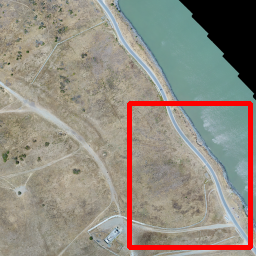

In [13]:
# Visualize the region of interest in the larger tile
zoom = 17
tile = next(tile_generator(bounds, zoom))
image = get_image(tile, img_info['tileLayerUrl'])
(min_x, min_y, max_x, max_y), intersection =  get_bounds_for_tile(bounds, tile)
visualize(image.copy(), min_y, min_x, max_y, max_x)



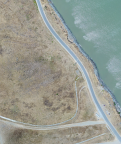

In [14]:
# Crop to the GeoBoundary
crop = image[min_x : max_x, min_y: max_y, :]
Image.fromarray(crop)

* <b>Run Model</b>
* This is where users can run model inferences.
* For this example we are detecting water with some simple image processing

In [15]:
# Mask out pixels that do not belong to water
# Clean up with some postprocessing
hsv = cv2.cvtColor(crop, cv2.COLOR_RGB2HSV)
mask = cv2.inRange(hsv, (50, 10, 25), (100, 150,255))
Image.fromarray(mask)
kernel = np.ones((5, 5), np.uint8)
mask = cv2.erode(mask, kernel) 
mask = cv2.dilate(mask, kernel) 

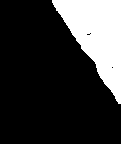

In [16]:
Image.fromarray(mask)

* <b>Convert Mask to WGS84 Polygons<b>

In [17]:
def extract_polygons(mask: np.ndarray) -> Polygon:
    # Turns a segementation mask into shapely polygons
    contours, _ = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
    polygons = []

    for cnt in contours:
        coords = []
        for point in cnt:
            coords.append([int(point[0][0]),int(point[0][1])] )
        polygons.append(coords)

    polygons = [Polygon(poly) for poly in polygons]
    return [poly.simplify(3) for poly in polygons if poly.area > 50]

def convert_to_wgs84(poly : Polygon, intersection: Polygon) -> List[GeoPoint]:
    # Turns pixel polygons into wgs84 polygons
    result = []
    for coord in poly.__geo_interface__['coordinates'][0]:
        x = intersection.bounds[1] + coord[0]
        y = intersection.bounds[0] + coord[1]
        result.append([x,y])
    points  = [Point.from_pixel(x,y, tile.z).latitude_longitude for (x,y) in result]
    return [GeoPoint(lat = lat, lng = lng) for lat, lng in points]

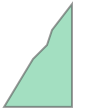

In [21]:
# Extract polygons


# Note that the y axis is different when rendering polygons than it is in images.
# This will appear correctly in labelbox
pixel_polygons = extract_polygons(mask)
pixel_polygons[0]

In [23]:
geo_polygons = [convert_to_wgs84(poly, intersection) for poly in pixel_polygons]

In [24]:
geo_polygons

[[GeoPoint(lat=37.87398109727749, lng=-122.31708884239197),
  GeoPoint(lat=37.87357458675811, lng=-122.31677770614624),
  GeoPoint(lat=37.87345602076741, lng=-122.3166275024414),
  GeoPoint(lat=37.87332898556559, lng=-122.3165738582611),
  GeoPoint(lat=37.8731087906969, lng=-122.31635928153993),
  GeoPoint(lat=37.87398109727749, lng=-122.31635928153993),
  GeoPoint(lat=37.87398109727749, lng=-122.31708884239197)]]

* <b>Create NDJson From Geo Polygons</b>

In [27]:
# Convert to ndjson

ndjson = []
datarow_id = next(dataset.data_rows()).uid

for geo_poly in geo_polygons:
    pts = [{'x': pt.lng, 'y': pt.lat} for pt in geo_poly]
    ndjson.append({
        "uuid": str(uuid.uuid4()),
        "schemaId": schema_lookup['water'],
        "dataRow": {
            "id": datarow_id
        },
        "polygon": pts
    })

* <b>Upload to Labelbox</b>

In [28]:
# Upload!
upload_task = project.upload_annotations(name=f"upload-job-{uuid.uuid4()}",
                                         annotations=ndjson,
                                         validate=False)

In [29]:
# Wait for upload to finish (Will take up to five minutes)
upload_task.wait_until_done()
# Review the upload status
print(upload_task.errors)

[]


In [30]:
upload_task.statuses

[{'uuid': '62191719-b221-42c5-a578-e3db00986d18',
  'dataRow': {'id': 'ckns6zh191ap40reu8j6u2cvk'},
  'status': 'SUCCESS'}]

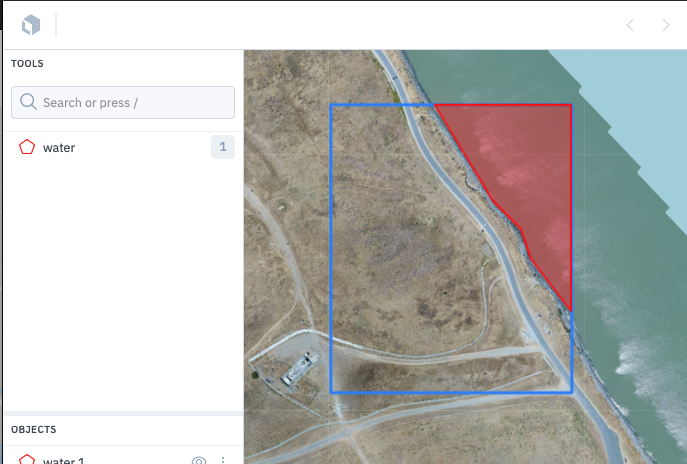